

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## Configuration


In [1]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
# pip install -U seaborn

In [2]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# set gpu memory
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
%reload_ext autoreload

### Initial Parameters

In [4]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

notebook_name_params = qbz95.utils.get_notebook_name().split('.')[0].split('_')

output_path = os.path.abspath('./output')
data_name = notebook_name_params[0]
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['cats', 'dogs']

train_image_count =  int(notebook_name_params[3])
use_data_augmentation = True if len(notebook_name_params)>=5 and notebook_name_params[4]=='aug' else False

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': use_data_augmentation,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*len(classes)/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': False,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': False,
            'schedule': lr_schedule,            
        }             
    },
    'fine_tune_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        }            
    },    
    'model_params':{
        'mlp':{'dropout':0.3, 'layer_count':1, 'units':128, 'epochs':20},
        'lenet':{'dropout':0.4, 'epochs':20},
        'custom':{'dropout':0.4, 'epochs':20},
        'vgg':{'dropout':0.4, 'epochs':20, 'learning_rate':0.001},
        'resnet':{'dropout':0.4, 'epochs':20},
        'pretrained':{'dropout':0.3, 'epochs':20, 'learning_rate':0.0001}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2022-08-17 05:59:38,552: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/results.json


In [5]:
params.use_data_augmentation

False

## Get Data

### Download Data 

In [6]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [7]:
!ls -l $train_dir
!ls -l $train_dir/cats | wc -l
!ls -l $train_dir/dogs | wc -l
!ls -l $train_dir/cats | head -5

!ls -l $validation_dir/cats | wc -l 
!ls -l $validation_dir/dogs | wc -l

total 84
drwxr-xr-x. 2 root root 24576 Aug 17 05:13 cats
drwxr-xr-x. 2 root root 24576 Aug 17 05:13 dogs
1001
1001
total 22644
-rw-r--r--. 1 root root 12414 Aug 17 05:59 cat.0.jpg
-rw-r--r--. 1 root root 16880 Aug 17 05:59 cat.1.jpg
-rw-r--r--. 1 root root 34315 Aug 17 05:59 cat.10.jpg
-rw-r--r--. 1 root root 28377 Aug 17 05:59 cat.100.jpg
ls: write error: Broken pipe
501
501


In [8]:
def image_to_array(img_file):
    img = load_img(img_file) 
    img = img.resize((160, 160))
    x = img_to_array(img) 
    return x

def images_to_array(image_folder):
    files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
    x = np.array([image_to_array(file) for file in files])
    return x 

def load_image_folder(image_folder, classes):
    x = None
    y = None
    for i, class_ in enumerate(classes):
        folder = os.path.join(image_folder, class_) 
        x_ = images_to_array(folder)
        y_ = [i]*len(x_)
        if x is None:
            x = x_
            y = y_
        else:
            x = np.concatenate([x, x_])
            y = np.concatenate([y, y_])
        
    return x, y

train_images, train_labels = load_image_folder(train_dir, params.classes)
print(train_images.shape, train_labels.shape)

test_images, test_labels = load_image_folder(validation_dir, params.classes)
print(test_images.shape, test_labels.shape)

(2000, 160, 160, 3) (2000,)
(1000, 160, 160, 3) (1000,)


In [9]:
if params.train_image_count*len(classes)<len(train_images):
    _, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*10, random_state=42)

    print(train_images.shape, train_labels.shape)
    print(test_images.shape, test_labels.shape)

In [10]:
Counter(train_labels)

Counter({0: 1000, 1: 1000})



### Data Explore 

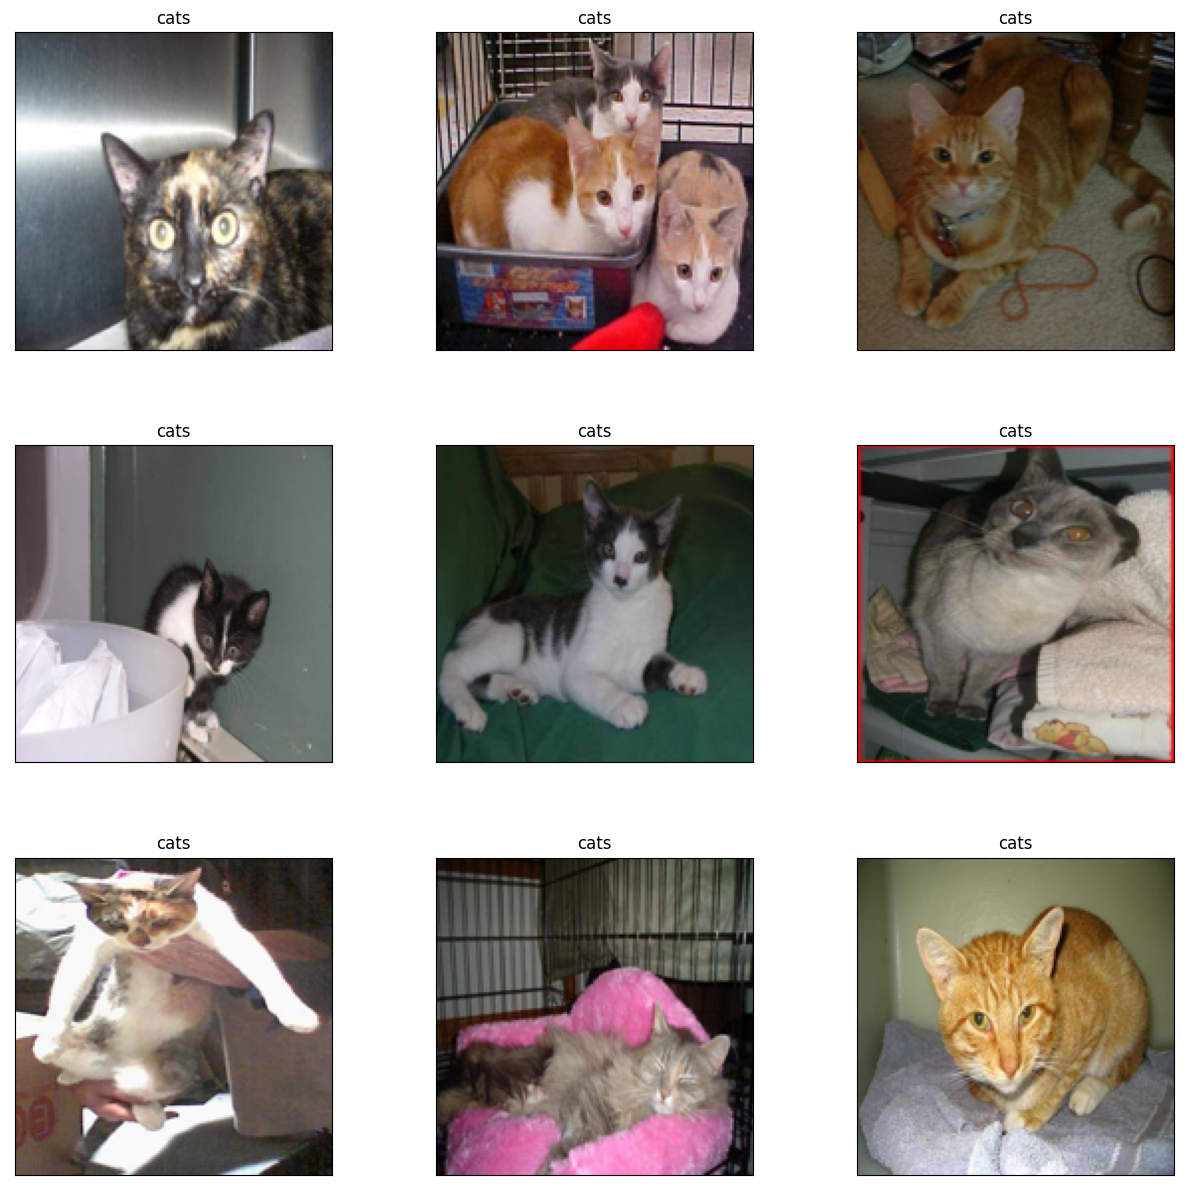

In [11]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=3, figsize=(12, 12))

### Class Distribution

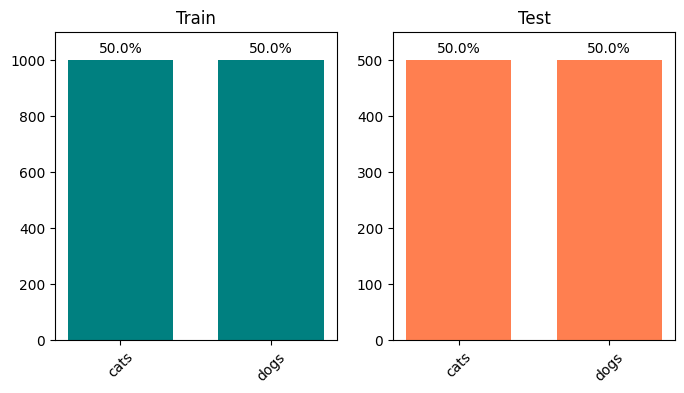

In [12]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## Prepare Data


### Raw Data


In [13]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [14]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [15]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 160, 160, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

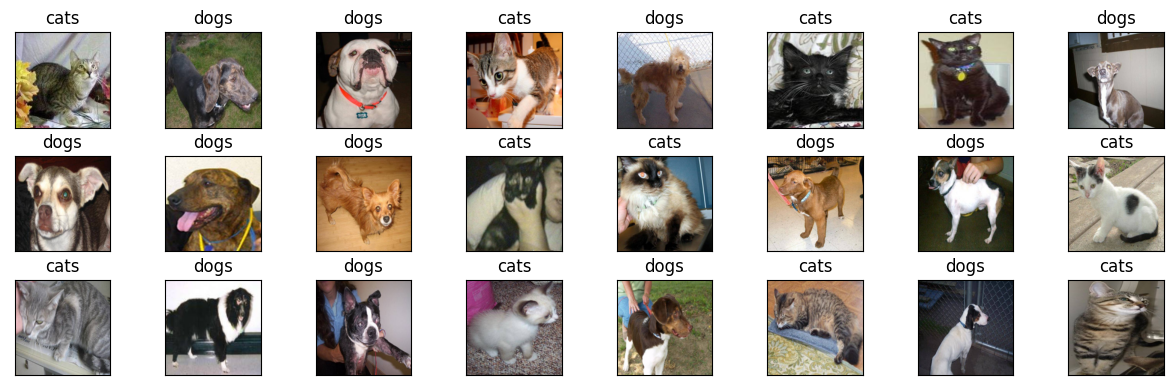

In [16]:
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### Data Augmentation

In [17]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

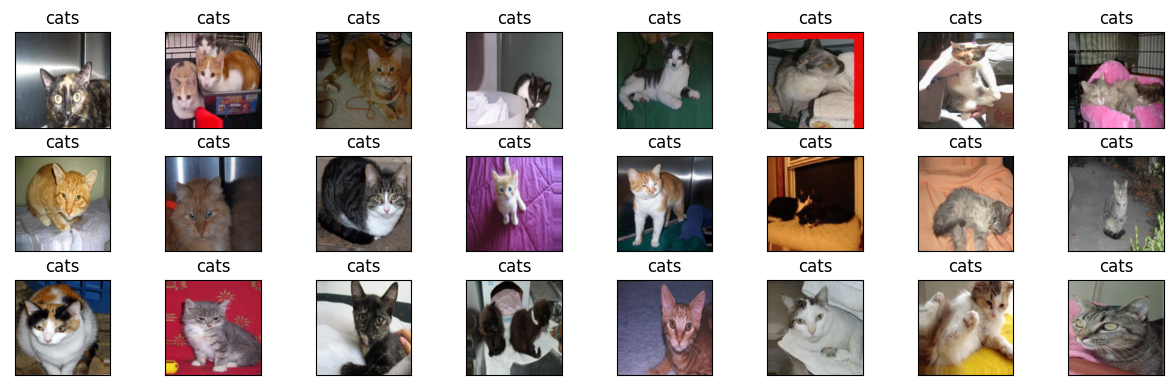

In [18]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

see orgin images

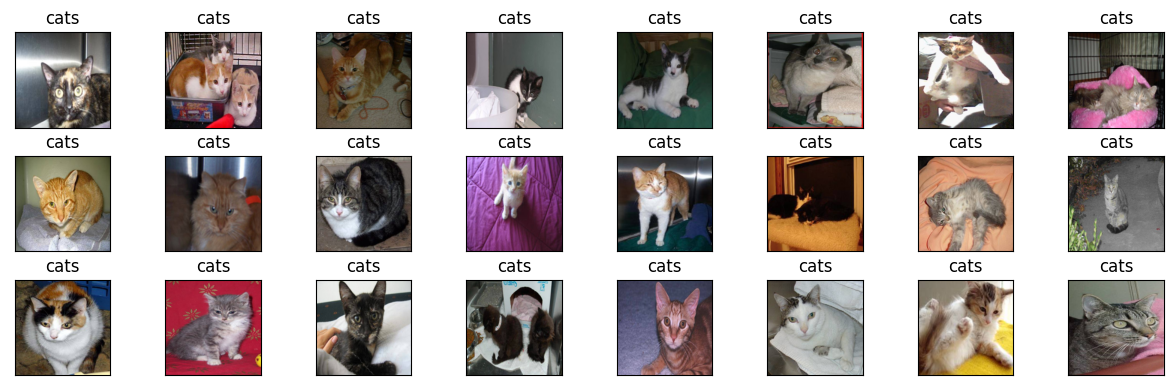

In [19]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

create data augment dataset

In [20]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [21]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


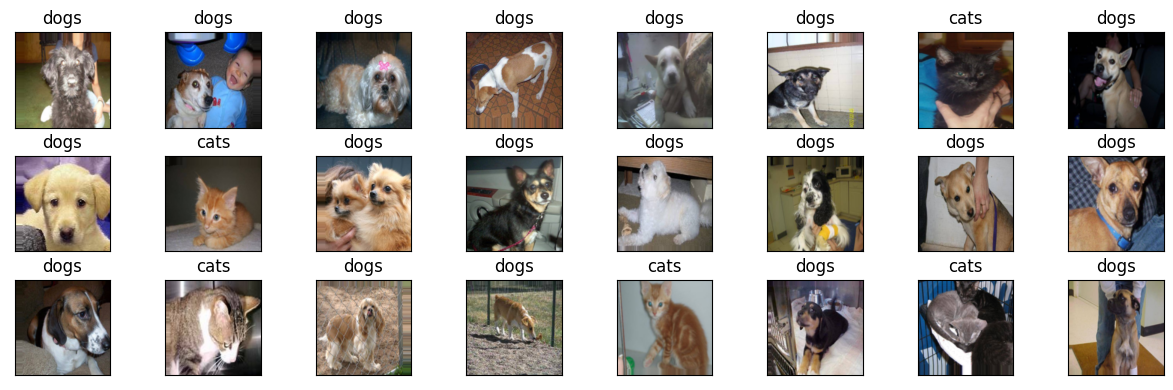

In [22]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

In [23]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)



##  Models



### MLP

2022-08-17 06:00:09,522: INFO: model_params.mlp1.dropout=0.3
2022-08-17 06:00:09,523: INFO: model_params.mlp1.layer_count=1
2022-08-17 06:00:09,524: INFO: model_params.mlp1.units=128
2022-08-17 06:00:09,764: INFO: learning_rate=0.001
2022-08-17 06:00:09,764: INFO: model_params.mlp1.clip_value=None
2022-08-17 06:00:09,775: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/mlp1


Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 flatten (Flatten)           (None, 76800)             0         
                                                                 
 dense (Dense)               (None, 128)               9830528   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 9,830,786
Trainable params: 9,830,786
Non-traina

2022-08-17 06:00:09,790: INFO: model_params.mlp1.epochs=20
2022-08-17 06:00:09,790: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/mlp1, monitor=val_accuracy)
2022-08-17 06:00:09,791: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 06:00:09,792: INFO: steps_per_epoch=62
2022-08-17 06:00:09,792: INFO: start training
2022-08-17 06:00:09,793: INFO: use_class_weight=False


Epoch 1/20
61/62 [============================>.] - ETA: 0s - loss: 12.1814 - accuracy: 0.5528INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/mlp1/assets


2022-08-17 06:00:13,262: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/mlp1/assets


62/62 [==============================] - 3s 42ms/step - loss: 12.1992 - accuracy: 0.5514 - val_loss: 8.4012 - val_accuracy: 0.5660
Epoch 2/20
60/62 [============================>.] - ETA: 0s - loss: 6.2997 - accuracy: 0.6062INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/mlp1/assets


2022-08-17 06:00:15,056: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/mlp1/assets


62/62 [==============================] - 2s 29ms/step - loss: 6.2165 - accuracy: 0.6064 - val_loss: 4.9989 - val_accuracy: 0.5740
Epoch 3/20
62/62 [==============================] - 1s 15ms/step - loss: 3.3793 - accuracy: 0.6542 - val_loss: 5.2662 - val_accuracy: 0.5730
Epoch 4/20
61/62 [============================>.] - ETA: 0s - loss: 3.1646 - accuracy: 0.6598INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/mlp1/assets


2022-08-17 06:00:17,832: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/mlp1/assets


62/62 [==============================] - 2s 29ms/step - loss: 3.1412 - accuracy: 0.6598 - val_loss: 4.1018 - val_accuracy: 0.5790
Epoch 5/20
62/62 [==============================] - 1s 9ms/step - loss: 2.1617 - accuracy: 0.6941 - val_loss: 3.9271 - val_accuracy: 0.5780
Epoch 6/20
62/62 [==============================] - 1s 9ms/step - loss: 1.6543 - accuracy: 0.7162 - val_loss: 4.0400 - val_accuracy: 0.5520
Epoch 7/20
62/62 [==============================] - 1s 9ms/step - loss: 1.3505 - accuracy: 0.7319 - val_loss: 3.7889 - val_accuracy: 0.5690
Epoch 8/20
62/62 [==============================] - 1s 9ms/step - loss: 1.0975 - accuracy: 0.7757 - val_loss: 4.1367 - val_accuracy: 0.5530
Epoch 9/20
62/62 [==============================] - 1s 9ms/step - loss: 0.8456 - accuracy: 0.7772 - val_loss: 3.7160 - val_accuracy: 0.5580
Epoch 10/20
62/62 [==============================] - 1s 9ms/step - loss: 0.8022 - accuracy: 0.7802 - val_loss: 3.6655 - val_accuracy: 0.5680
Epoch 11/20
62/62 [==========

2022-08-17 06:00:23,769: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/mlp1/assets


62/62 [==============================] - 1s 23ms/step - loss: 0.4949 - accuracy: 0.8236 - val_loss: 3.3570 - val_accuracy: 0.5810
Epoch 14/20
57/62 [==========================>...] - ETA: 0s - loss: 0.5220 - accuracy: 0.8322INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/mlp1/assets


2022-08-17 06:00:25,175: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/mlp1/assets


62/62 [==============================] - 1s 23ms/step - loss: 0.5491 - accuracy: 0.8296 - val_loss: 3.5573 - val_accuracy: 0.5840
Epoch 15/20
62/62 [==============================] - 1s 9ms/step - loss: 0.4785 - accuracy: 0.8407 - val_loss: 3.2289 - val_accuracy: 0.5820
Epoch 16/20
57/62 [==========================>...] - ETA: 0s - loss: 0.3614 - accuracy: 0.8536INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/mlp1/assets


2022-08-17 06:00:27,293: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/mlp1/assets


62/62 [==============================] - 2s 25ms/step - loss: 0.3723 - accuracy: 0.8579 - val_loss: 3.1192 - val_accuracy: 0.5910
Epoch 17/20
62/62 [==============================] - 1s 9ms/step - loss: 0.4148 - accuracy: 0.8664 - val_loss: 3.0167 - val_accuracy: 0.5740
Epoch 18/20
62/62 [==============================] - 1s 9ms/step - loss: 0.3595 - accuracy: 0.8765 - val_loss: 3.6759 - val_accuracy: 0.5770
Epoch 19/20
57/62 [==========================>...] - ETA: 0s - loss: 0.3669 - accuracy: 0.8750INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/mlp1/assets


2022-08-17 06:00:29,804: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/mlp1/assets


62/62 [==============================] - 1s 23ms/step - loss: 0.3681 - accuracy: 0.8760 - val_loss: 3.3658 - val_accuracy: 0.5970
Epoch 20/20
62/62 [==============================] - 1s 9ms/step - loss: 0.4133 - accuracy: 0.8725 - val_loss: 3.6211 - val_accuracy: 0.5890


2022-08-17 06:00:30,398: INFO: finish training [elapsed time: 20.61 seconds]


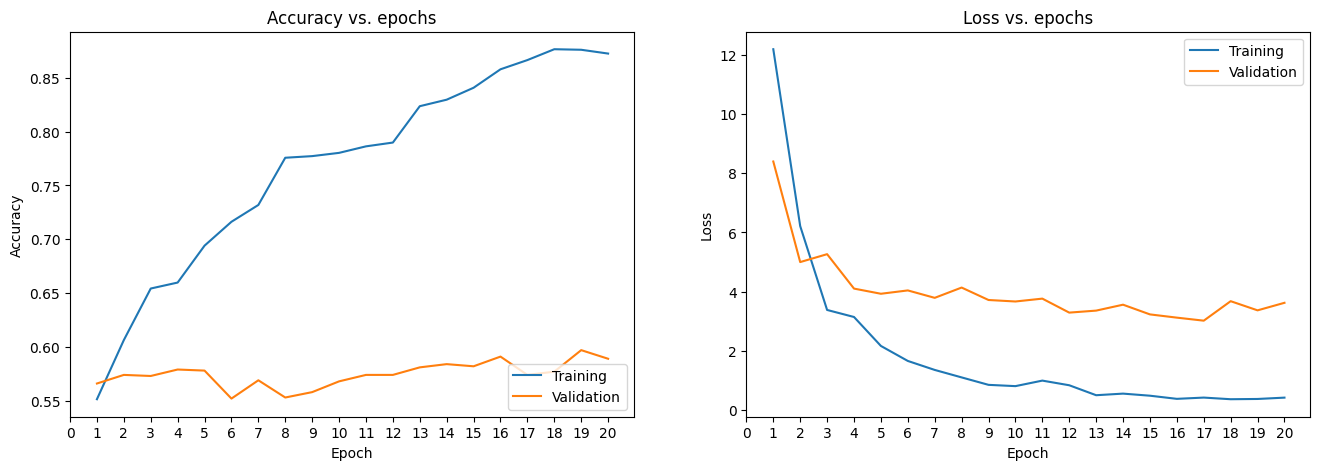

2022-08-17 06:00:30,823: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/mlp1
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 0s 5ms/step


2022-08-17 06:00:37,513: INFO: test loss:3.3658
2022-08-17 06:00:37,514: INFO: test accuracy:0.5970
2022-08-17 06:00:37,515: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/results.json
2022-08-17 06:00:37,516: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/results.json
2022-08-17 06:00:37,517: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator
2022-08-17 06:00:37,518: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator
2022-08-17 06:00:37,519: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_10

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-17 06:00:38,471: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator


32/32 [==============================] - 2s 11ms/step


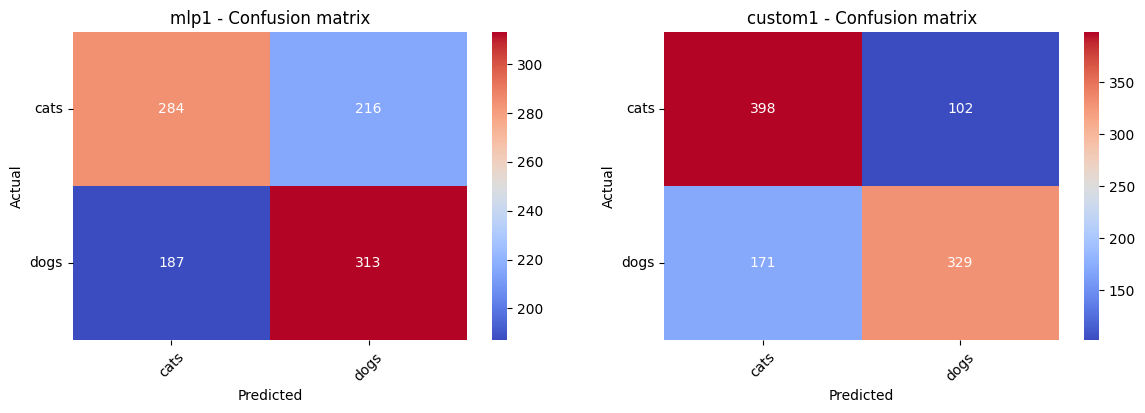

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1    custom1  catsdogs_0808_cnt_1000.ipynb        1383938        84.8   
2     lenet1  catsdogs_0808_cnt_1000.ipynb        2785850        47.0   
3       mlp1  catsdogs_0808_cnt_1000.ipynb        9830786        20.6   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-17 05:54      0.0990     1.2170          0.9615          0.727   
2  2022-08-17 05:52      0.0867     1.2108          0.9675          0.681   
3  2022-08-17 06:00      0.2677     3.3658          0.9190          0.597   

   train_auc  test_auc  
1     0.9941    0.7947  
2     0.9961    0.7477  
3     0.9722    0.6200

In [24]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 




### LeNet

![image-20201019113632136](images/image-20201019113632136.png)


2022-08-17 06:00:42,117: INFO: model_params.lenet1.dropout=0.4
2022-08-17 06:00:42,205: INFO: learning_rate=0.001
2022-08-17 06:00:42,206: INFO: model_params.lenet1.clip_value=None
2022-08-17 06:00:42,212: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/lenet1


Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 6)       456       
                                                                 
 batch_normalization (BatchN  (None, 160, 160, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 6)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 80, 80, 6)         0    

2022-08-17 06:00:42,241: INFO: model_params.lenet1.epochs=20
2022-08-17 06:00:42,242: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/lenet1, monitor=val_accuracy)
2022-08-17 06:00:42,243: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 06:00:42,243: INFO: steps_per_epoch=62
2022-08-17 06:00:42,244: INFO: start training
2022-08-17 06:00:42,244: INFO: use_class_weight=False


Epoch 1/20
61/62 [============================>.] - ETA: 0s - loss: 1.8387 - accuracy: 0.4964

2022-08-17 06:00:45,822: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/lenet1/assets


2022-08-17 06:00:46,461: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/lenet1/assets


62/62 [==============================] - 4s 55ms/step - loss: 1.8199 - accuracy: 0.4970 - val_loss: 1.4103 - val_accuracy: 0.5080
Epoch 2/20
62/62 [==============================] - 1s 17ms/step - loss: 0.7061 - accuracy: 0.4945 - val_loss: 1.7673 - val_accuracy: 0.5010
Epoch 3/20
61/62 [============================>.] - ETA: 0s - loss: 0.7010 - accuracy: 0.4995

2022-08-17 06:00:49,851: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/lenet1/assets


2022-08-17 06:00:50,527: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/lenet1/assets


62/62 [==============================] - 3s 49ms/step - loss: 0.7008 - accuracy: 0.5015 - val_loss: 1.7274 - val_accuracy: 0.5140
Epoch 4/20
62/62 [==============================] - 1s 18ms/step - loss: 0.6952 - accuracy: 0.5000 - val_loss: 1.8235 - val_accuracy: 0.4960
Epoch 5/20
61/62 [============================>.] - ETA: 0s - loss: 0.6944 - accuracy: 0.5046

2022-08-17 06:00:53,940: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/lenet1/assets


2022-08-17 06:00:54,579: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/lenet1/assets


62/62 [==============================] - 3s 48ms/step - loss: 0.6944 - accuracy: 0.5060 - val_loss: 1.4738 - val_accuracy: 0.5300
Epoch 6/20
61/62 [============================>.] - ETA: 0s - loss: 0.6972 - accuracy: 0.4769

2022-08-17 06:00:57,175: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/lenet1/assets


2022-08-17 06:00:57,810: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/lenet1/assets


62/62 [==============================] - 3s 53ms/step - loss: 0.6971 - accuracy: 0.4783 - val_loss: 1.4848 - val_accuracy: 0.5460
Epoch 7/20
61/62 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.4903

2022-08-17 06:01:00,216: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/lenet1/assets


2022-08-17 06:01:00,873: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/lenet1/assets


62/62 [==============================] - 3s 50ms/step - loss: 0.6933 - accuracy: 0.4929 - val_loss: 1.3597 - val_accuracy: 0.5490
Epoch 8/20
62/62 [==============================] - 1s 17ms/step - loss: 0.6929 - accuracy: 0.4889 - val_loss: 1.3134 - val_accuracy: 0.5440
Epoch 9/20
62/62 [==============================] - 1s 18ms/step - loss: 0.6931 - accuracy: 0.4703 - val_loss: 1.2770 - val_accuracy: 0.5390
Epoch 10/20
62/62 [==============================] - 1s 18ms/step - loss: 0.6926 - accuracy: 0.4929 - val_loss: 1.2214 - val_accuracy: 0.5340
Epoch 11/20
62/62 [==============================] - 1s 17ms/step - loss: 0.6930 - accuracy: 0.5131 - val_loss: 1.2270 - val_accuracy: 0.5320
Epoch 12/20
62/62 [==============================] - 1s 17ms/step - loss: 0.6930 - accuracy: 0.4899 - val_loss: 1.2008 - val_accuracy: 0.5350
Epoch 13/20
62/62 [==============================] - 1s 17ms/step - loss: 0.6931 - accuracy: 0.5035 - val_loss: 1.1358 - val_accuracy: 0.5400
Epoch 14/20
62/62 [=

2022-08-17 06:01:14,984: INFO: finish training [elapsed time: 32.74 seconds]


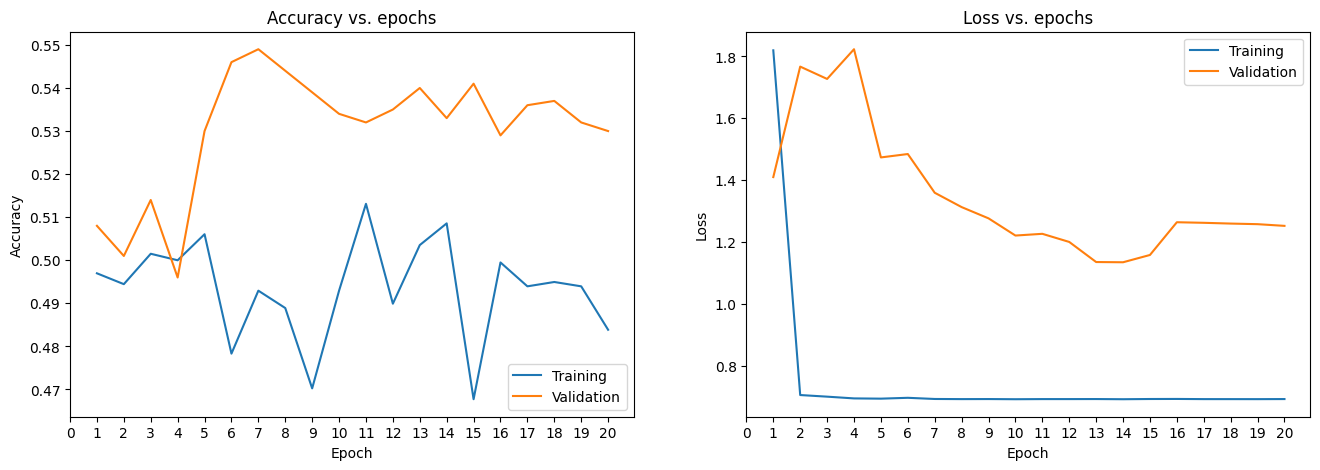

2022-08-17 06:01:15,415: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/lenet1
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 1s 6ms/step


2022-08-17 06:01:22,791: INFO: test loss:1.3597
2022-08-17 06:01:22,792: INFO: test accuracy:0.5490
2022-08-17 06:01:22,794: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/results.json
2022-08-17 06:01:22,795: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/results.json
2022-08-17 06:01:22,796: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator
2022-08-17 06:01:22,797: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator
2022-08-17 06:01:22,797: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_10

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-17 06:01:24,072: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator


32/32 [==============================] - 1s 14ms/step


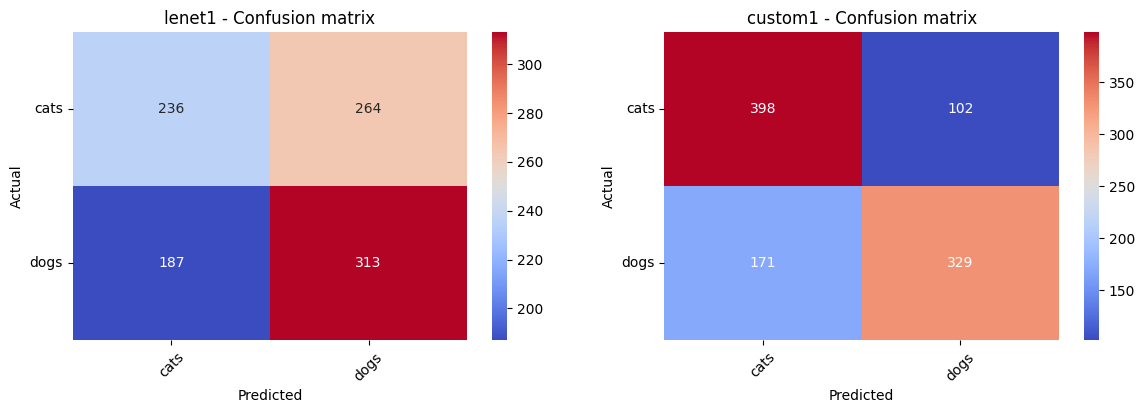

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1    custom1  catsdogs_0808_cnt_1000.ipynb        1383938        84.8   
2       mlp1  catsdogs_0808_cnt_1000.ipynb        9830786        20.6   
3     lenet1  catsdogs_0808_cnt_1000.ipynb        2785850        32.7   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-17 05:54      0.0990     1.2170          0.9615          0.727   
2  2022-08-17 06:00      0.2677     3.3658          0.9190          0.597   
3  2022-08-17 06:01      1.3731     1.3597          0.5400          0.549   

   train_auc  test_auc  
1     0.9941    0.7947  
2     0.9722    0.6200  
3     0.5511    0.5673

In [25]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Custom 1


2022-08-17 06:01:27,100: INFO: model_params.custom1.dropout=0.4
2022-08-17 06:01:27,210: INFO: learning_rate=0.001
2022-08-17 06:01:27,211: INFO: model_params.custom1.clip_value=None
2022-08-17 06:01:27,217: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1


Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 160, 160, 32)      896       
                                                                 
 batch_normalization_2 (Batc  (None, 160, 160, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 80, 80, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 80, 80, 32)        0   

2022-08-17 06:01:27,250: INFO: model_params.custom1.epochs=20
2022-08-17 06:01:27,250: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1, monitor=val_accuracy)
2022-08-17 06:01:27,251: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 06:01:27,252: INFO: steps_per_epoch=62
2022-08-17 06:01:27,252: INFO: start training
2022-08-17 06:01:27,253: INFO: use_class_weight=False


Epoch 1/20
61/62 [============================>.] - ETA: 0s - loss: 1.1401 - accuracy: 0.5179

2022-08-17 06:01:33,562: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


2022-08-17 06:01:34,250: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 7s 93ms/step - loss: 1.1329 - accuracy: 0.5166 - val_loss: 3.9719 - val_accuracy: 0.5000
Epoch 2/20
62/62 [==============================] - 2s 38ms/step - loss: 0.6910 - accuracy: 0.5423 - val_loss: 2.5188 - val_accuracy: 0.4980
Epoch 3/20
62/62 [==============================] - 5s 79ms/step - loss: 0.6932 - accuracy: 0.5297 - val_loss: 6.7336 - val_accuracy: 0.5000
Epoch 4/20
62/62 [==============================] - ETA: 0s - loss: 0.6713 - accuracy: 0.5605

2022-08-17 06:01:47,777: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


2022-08-17 06:01:48,491: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 7s 114ms/step - loss: 0.6713 - accuracy: 0.5605 - val_loss: 1.9417 - val_accuracy: 0.5020
Epoch 5/20
62/62 [==============================] - ETA: 0s - loss: 0.6681 - accuracy: 0.5675

2022-08-17 06:01:55,341: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


2022-08-17 06:01:56,045: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 8s 123ms/step - loss: 0.6681 - accuracy: 0.5675 - val_loss: 1.6641 - val_accuracy: 0.5030
Epoch 6/20
62/62 [==============================] - 5s 82ms/step - loss: 0.6665 - accuracy: 0.5857 - val_loss: 1.4916 - val_accuracy: 0.5010
Epoch 7/20
62/62 [==============================] - ETA: 0s - loss: 0.6493 - accuracy: 0.5927

2022-08-17 06:02:07,629: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


2022-08-17 06:02:08,303: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 7s 116ms/step - loss: 0.6493 - accuracy: 0.5927 - val_loss: 0.9613 - val_accuracy: 0.5530
Epoch 8/20
61/62 [============================>.] - ETA: 0s - loss: 0.6472 - accuracy: 0.5963

2022-08-17 06:02:12,062: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


2022-08-17 06:02:12,957: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 5s 76ms/step - loss: 0.6472 - accuracy: 0.5943 - val_loss: 0.6875 - val_accuracy: 0.6020
Epoch 9/20
62/62 [==============================] - 3s 47ms/step - loss: 0.6391 - accuracy: 0.6235 - val_loss: 0.8392 - val_accuracy: 0.5500
Epoch 10/20
61/62 [============================>.] - ETA: 0s - loss: 0.6612 - accuracy: 0.6081

2022-08-17 06:02:20,372: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


2022-08-17 06:02:21,109: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 5s 86ms/step - loss: 0.6605 - accuracy: 0.6079 - val_loss: 0.8659 - val_accuracy: 0.6130
Epoch 11/20
62/62 [==============================] - 3s 48ms/step - loss: 0.6306 - accuracy: 0.6295 - val_loss: 2.3220 - val_accuracy: 0.5430
Epoch 12/20
62/62 [==============================] - 3s 52ms/step - loss: 0.6085 - accuracy: 0.6472 - val_loss: 2.1825 - val_accuracy: 0.5360
Epoch 13/20
62/62 [==============================] - 3s 48ms/step - loss: 0.5885 - accuracy: 0.6704 - val_loss: 1.2558 - val_accuracy: 0.5900
Epoch 14/20
61/62 [============================>.] - ETA: 0s - loss: 0.5922 - accuracy: 0.6670

2022-08-17 06:02:34,822: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


2022-08-17 06:02:35,538: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 5s 85ms/step - loss: 0.5918 - accuracy: 0.6658 - val_loss: 0.9296 - val_accuracy: 0.6290
Epoch 15/20
61/62 [============================>.] - ETA: 0s - loss: 0.5805 - accuracy: 0.6880

2022-08-17 06:02:40,011: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


2022-08-17 06:02:41,033: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 5s 89ms/step - loss: 0.5798 - accuracy: 0.6875 - val_loss: 1.0363 - val_accuracy: 0.6400
Epoch 16/20
62/62 [==============================] - ETA: 0s - loss: 0.5602 - accuracy: 0.6830

2022-08-17 06:02:45,580: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


2022-08-17 06:02:46,308: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 5s 86ms/step - loss: 0.5602 - accuracy: 0.6830 - val_loss: 0.6893 - val_accuracy: 0.6430
Epoch 17/20
62/62 [==============================] - ETA: 0s - loss: 0.5400 - accuracy: 0.6925

2022-08-17 06:02:50,819: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


2022-08-17 06:02:51,544: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 5s 85ms/step - loss: 0.5400 - accuracy: 0.6925 - val_loss: 0.7141 - val_accuracy: 0.6770
Epoch 18/20
62/62 [==============================] - ETA: 0s - loss: 0.5075 - accuracy: 0.7283

2022-08-17 06:02:56,027: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


2022-08-17 06:02:57,039: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 5s 89ms/step - loss: 0.5075 - accuracy: 0.7283 - val_loss: 0.6811 - val_accuracy: 0.6780
Epoch 19/20
62/62 [==============================] - 3s 48ms/step - loss: 0.5028 - accuracy: 0.7344 - val_loss: 0.9395 - val_accuracy: 0.6480
Epoch 20/20
61/62 [============================>.] - ETA: 0s - loss: 0.4879 - accuracy: 0.7346

2022-08-17 06:03:04,514: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


2022-08-17 06:03:05,243: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1/assets


62/62 [==============================] - 5s 85ms/step - loss: 0.4868 - accuracy: 0.7354 - val_loss: 0.6511 - val_accuracy: 0.6870


2022-08-17 06:03:05,317: INFO: finish training [elapsed time: 98.07 seconds]


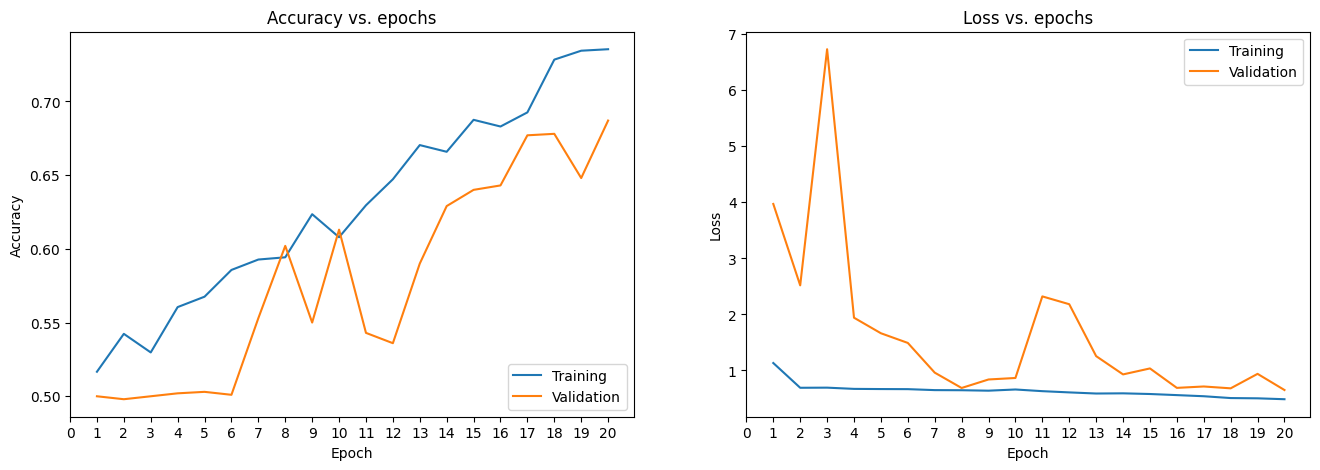

2022-08-17 06:03:05,759: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 1s 11ms/step


2022-08-17 06:03:14,649: INFO: test loss:0.6511
2022-08-17 06:03:14,650: INFO: test accuracy:0.6870
2022-08-17 06:03:14,652: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/results.json
2022-08-17 06:03:14,653: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/results.json
2022-08-17 06:03:14,654: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator
2022-08-17 06:03:14,655: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator
2022-08-17 06:03:14,656: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_10

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-17 06:03:15,109: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator


32/32 [==============================] - 1s 5ms/step


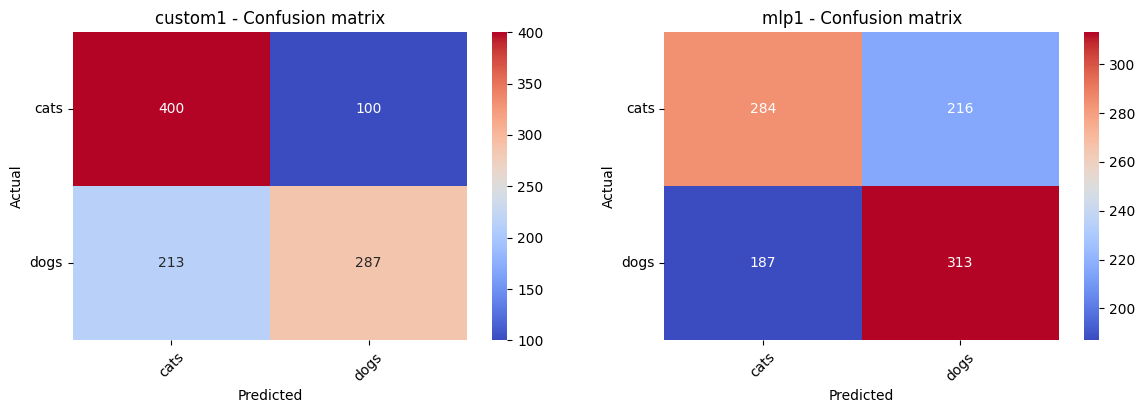

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1    custom1  catsdogs_0808_cnt_1000.ipynb        1383938        98.1   
2       mlp1  catsdogs_0808_cnt_1000.ipynb        9830786        20.6   
3     lenet1  catsdogs_0808_cnt_1000.ipynb        2785850        32.7   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-17 06:03      0.4033     0.6511          0.8155          0.687   
2  2022-08-17 06:00      0.2677     3.3658          0.9190          0.597   
3  2022-08-17 06:01      1.3731     1.3597          0.5400          0.549   

   train_auc  test_auc  
1     0.9068    0.7664  
2     0.9722    0.6200  
3     0.5511    0.5673

In [26]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### VGG

In [27]:
rescale1 = tf.keras.layers.Rescaling(1./255.0)
for data, label in datasets.train_dataset.take(1):
    print(data[0][0][0:5]) 
    print(rescale(data)[0][0][0:5])  

tf.Tensor(
[[129. 135. 146.]
 [101. 112. 116.]
 [ 77.  93.  84.]
 [ 81.  99.  73.]
 [ 84. 103.  67.]], shape=(5, 3), dtype=float32)
tf.Tensor(
[[ 0.01176476  0.05882359  0.14509809]
 [-0.20784307 -0.12156856 -0.09019601]
 [-0.3960784  -0.27058822 -0.34117645]
 [-0.36470586 -0.22352934 -0.42745095]
 [-0.34117645 -0.19215679 -0.47450978]], shape=(5, 3), dtype=float32)


In [28]:

helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3, 
                                             preprocess_fun=rescale)
model.summary()


2022-08-17 06:03:18,732: INFO: model_params.vgg8.dropout=0.4
2022-08-17 06:03:18,921: INFO: model_params.vgg8.learning_rate=0.001
2022-08-17 06:03:18,922: INFO: model_params.vgg8.clip_value=None
2022-08-17 06:03:18,930: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/vgg8


Model: "vgg8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 block1_con1 (Conv2D)        (None, 160, 160, 64)      1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 160, 160, 64)     256       
 ion)                                                            
                                                                 
 block1_relu1 (ReLU)         (None, 160, 160, 64)      0         
                                                                 
 block1_con2 (Conv2D)        (None, 160, 160, 64)      36928     
                                                              

2022-08-17 06:03:19,067: INFO: model_params.vgg8.epochs=20
2022-08-17 06:03:19,068: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/vgg8, monitor=val_accuracy)
2022-08-17 06:03:19,068: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 06:03:19,069: INFO: steps_per_epoch=62
2022-08-17 06:03:19,070: INFO: start training
2022-08-17 06:03:19,070: INFO: use_class_weight=False


Epoch 1/20
62/62 [==============================] - ETA: 0s - loss: 10.8826 - accuracy: 0.5222

2022-08-17 06:03:38,317: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/vgg8/assets


2022-08-17 06:03:39,771: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/vgg8/assets


62/62 [==============================] - 21s 303ms/step - loss: 10.8826 - accuracy: 0.5222 - val_loss: 0.7352 - val_accuracy: 0.5270
Epoch 2/20
62/62 [==============================] - 14s 223ms/step - loss: 0.6930 - accuracy: 0.5323 - val_loss: 0.6937 - val_accuracy: 0.4990
Epoch 3/20
62/62 [==============================] - 14s 223ms/step - loss: 0.6867 - accuracy: 0.5272 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 4/20
62/62 [==============================] - 14s 222ms/step - loss: 0.6843 - accuracy: 0.5439 - val_loss: 0.6956 - val_accuracy: 0.5100
Epoch 5/20
62/62 [==============================] - ETA: 0s - loss: 0.6765 - accuracy: 0.5595

2022-08-17 06:04:37,599: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/vgg8/assets


2022-08-17 06:04:39,087: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/vgg8/assets


62/62 [==============================] - 18s 292ms/step - loss: 0.6765 - accuracy: 0.5595 - val_loss: 0.6952 - val_accuracy: 0.5430
Epoch 6/20
62/62 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.5454

2022-08-17 06:04:55,266: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/vgg8/assets


2022-08-17 06:04:56,707: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/vgg8/assets


62/62 [==============================] - 18s 286ms/step - loss: 0.6869 - accuracy: 0.5454 - val_loss: 0.6896 - val_accuracy: 0.5520
Epoch 7/20
62/62 [==============================] - 14s 223ms/step - loss: 0.6781 - accuracy: 0.5524 - val_loss: 0.6913 - val_accuracy: 0.5320
Epoch 8/20
62/62 [==============================] - 15s 245ms/step - loss: 0.6761 - accuracy: 0.5494 - val_loss: 0.6838 - val_accuracy: 0.5500
Epoch 9/20
62/62 [==============================] - 16s 249ms/step - loss: 0.6778 - accuracy: 0.5519 - val_loss: 0.6837 - val_accuracy: 0.5350
Epoch 10/20
62/62 [==============================] - ETA: 0s - loss: 0.6737 - accuracy: 0.5499

2022-08-17 06:05:55,004: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/vgg8/assets


2022-08-17 06:05:56,407: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/vgg8/assets


62/62 [==============================] - 15s 247ms/step - loss: 0.6737 - accuracy: 0.5499 - val_loss: 0.6842 - val_accuracy: 0.5540
Epoch 11/20
62/62 [==============================] - 13s 218ms/step - loss: 0.6724 - accuracy: 0.5655 - val_loss: 0.6883 - val_accuracy: 0.5480
Epoch 12/20
62/62 [==============================] - 14s 223ms/step - loss: 0.6690 - accuracy: 0.5640 - val_loss: 0.6908 - val_accuracy: 0.5330
Epoch 13/20
62/62 [==============================] - 14s 223ms/step - loss: 0.6641 - accuracy: 0.5600 - val_loss: 0.6849 - val_accuracy: 0.5470
Epoch 14/20
62/62 [==============================] - 14s 223ms/step - loss: 0.6659 - accuracy: 0.5680 - val_loss: 0.6819 - val_accuracy: 0.5490
Epoch 15/20
62/62 [==============================] - 14s 223ms/step - loss: 0.6606 - accuracy: 0.5630 - val_loss: 0.6946 - val_accuracy: 0.5440
Epoch 16/20
62/62 [==============================] - 14s 222ms/step - loss: 0.6639 - accuracy: 0.5585 - val_loss: 0.6891 - val_accuracy: 0.5530
Epoc

2022-08-17 06:08:14,020: INFO: finish training [elapsed time: 294.95 seconds]


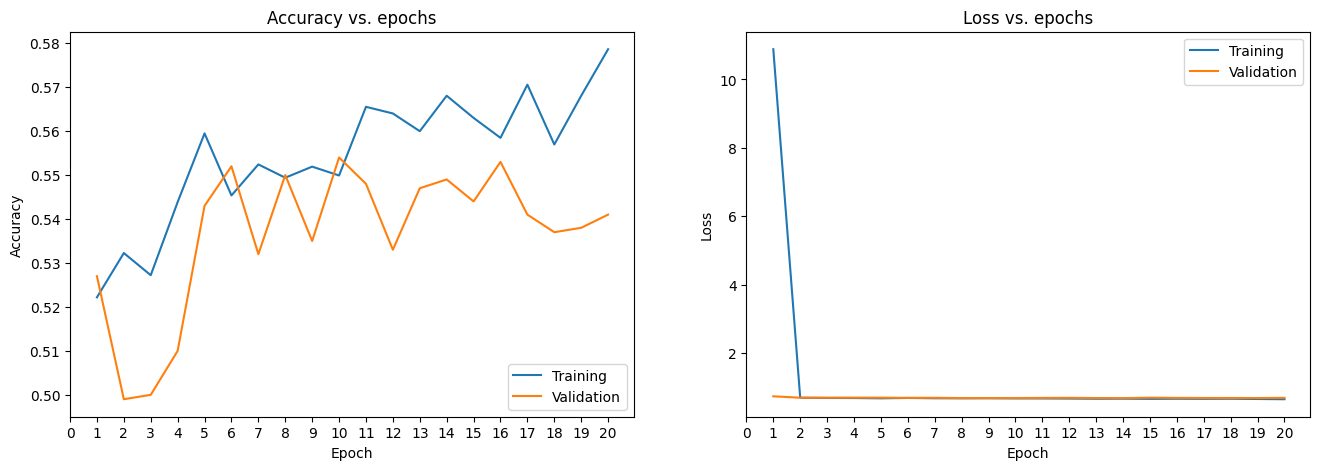

2022-08-17 06:08:14,475: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/vgg8
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 2s 53ms/step


2022-08-17 06:08:32,298: INFO: test loss:0.6842
2022-08-17 06:08:32,299: INFO: test accuracy:0.5540
2022-08-17 06:08:32,301: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/results.json
2022-08-17 06:08:32,303: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/results.json
2022-08-17 06:08:32,303: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator
2022-08-17 06:08:32,304: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator
2022-08-17 06:08:32,305: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_10

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-17 06:08:33,338: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator


32/32 [==============================] - 1s 12ms/step


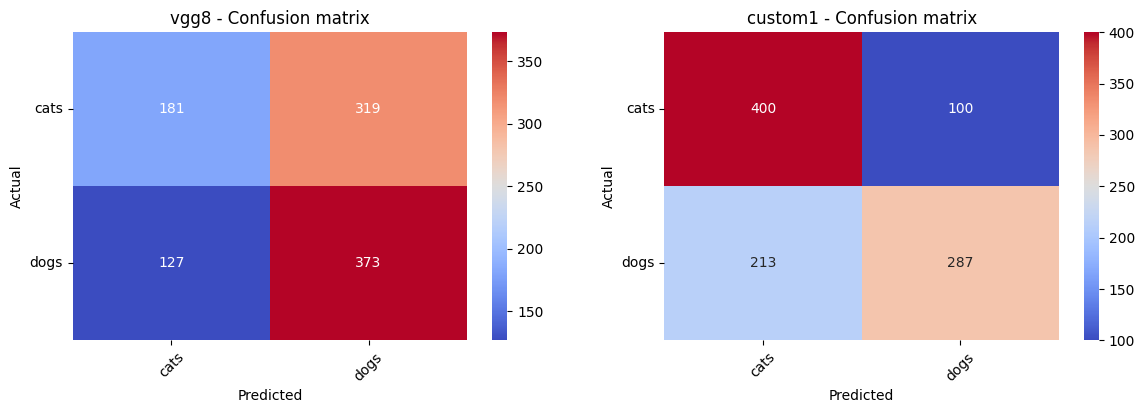

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1    custom1  catsdogs_0808_cnt_1000.ipynb        1383938        98.1   
2       mlp1  catsdogs_0808_cnt_1000.ipynb        9830786        20.6   
3       vgg8  catsdogs_0808_cnt_1000.ipynb       14254786       295.0   
4     lenet1  catsdogs_0808_cnt_1000.ipynb        2785850        32.7   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-17 06:03      0.4033     0.6511          0.8155          0.687   
2  2022-08-17 06:00      0.2677     3.3658          0.9190          0.597   
3  2022-08-17 06:08      0.6639     0.6842          0.5955          0.554   
4  2022-08-17 06:01      1.3731     1.3597          0.5400          0.549   

   train_auc  test_auc  
1     0.9068    0.7664  
2     0.9722    0.6200  
3     0.6396    0.5746  
4     0.5511    0.5673

In [29]:
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Resnet

see https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

2022-08-17 06:08:38,649: INFO: learning_rate=0.001
2022-08-17 06:08:38,650: INFO: model_params.resnet_v1_20.clip_value=None
2022-08-17 06:08:38,657: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/resnet_v1_20


Model: "resnet_v1_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 160, 160, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 160, 160, 16  448         ['rescaling[4][0]']              
                                )                                                                 
                                                                                       

 ormalization)                                                                                    
                                                                                                  
 activation_7 (Activation)      (None, 80, 80, 32)   0           ['batch_normalization_12[0][0]'] 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 80, 80, 32)   9248        ['activation_7[0][0]']           
                                                                                                  
 conv2d_14 (Conv2D)             (None, 80, 80, 32)   544         ['activation_6[0][0]']           
                                                                                                  
 batch_normalization_13 (BatchN  (None, 80, 80, 32)  128         ['conv2d_13[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 activation_16 (Activation)     (None, 40, 40, 64)   0           ['add_7[0][0]']                  
                                                                                                  
 conv2d_24 (Conv2D)             (None, 40, 40, 64)   36928       ['activation_16[0][0]']          
                                                                                                  
 batch_normalization_22 (BatchN  (None, 40, 40, 64)  256         ['conv2d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 40, 40, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_25

2022-08-17 06:08:38,789: INFO: model_params.resnet_v1_20.epochs=20
2022-08-17 06:08:38,790: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/resnet_v1_20, monitor=val_accuracy)
2022-08-17 06:08:38,790: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 06:08:38,791: INFO: steps_per_epoch=62
2022-08-17 06:08:38,792: INFO: start training
2022-08-17 06:08:38,792: INFO: use_class_weight=False


Epoch 1/20
62/62 [==============================] - ETA: 0s - loss: 1.2712 - accuracy: 0.5716

2022-08-17 06:09:02,022: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/resnet_v1_20/assets


2022-08-17 06:09:05,100: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/resnet_v1_20/assets


62/62 [==============================] - 27s 373ms/step - loss: 1.2712 - accuracy: 0.5716 - val_loss: 0.9006 - val_accuracy: 0.5600
Epoch 2/20
62/62 [==============================] - 12s 191ms/step - loss: 0.7509 - accuracy: 0.6951 - val_loss: 1.1606 - val_accuracy: 0.5150
Epoch 3/20
62/62 [==============================] - ETA: 0s - loss: 0.6483 - accuracy: 0.7591

2022-08-17 06:09:36,138: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/resnet_v1_20/assets


2022-08-17 06:09:39,395: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/resnet_v1_20/assets


62/62 [==============================] - 22s 365ms/step - loss: 0.6483 - accuracy: 0.7591 - val_loss: 0.8117 - val_accuracy: 0.6490
Epoch 4/20
62/62 [==============================] - 16s 252ms/step - loss: 0.5447 - accuracy: 0.8206 - val_loss: 0.8873 - val_accuracy: 0.6130
Epoch 5/20
62/62 [==============================] - 12s 192ms/step - loss: 0.4688 - accuracy: 0.8684 - val_loss: 1.0707 - val_accuracy: 0.6210
Epoch 6/20
62/62 [==============================] - ETA: 0s - loss: 0.5369 - accuracy: 0.8236

2022-08-17 06:10:26,301: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/resnet_v1_20/assets


2022-08-17 06:10:29,384: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/resnet_v1_20/assets


62/62 [==============================] - 22s 365ms/step - loss: 0.5369 - accuracy: 0.8236 - val_loss: 1.1115 - val_accuracy: 0.6630
Epoch 7/20
62/62 [==============================] - 12s 192ms/step - loss: 0.6045 - accuracy: 0.7999 - val_loss: 1.6455 - val_accuracy: 0.5710
Epoch 8/20
62/62 [==============================] - 12s 192ms/step - loss: 0.5087 - accuracy: 0.8498 - val_loss: 0.9905 - val_accuracy: 0.6490
Epoch 9/20
62/62 [==============================] - ETA: 0s - loss: 0.3713 - accuracy: 0.9078

2022-08-17 06:11:12,352: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/resnet_v1_20/assets


2022-08-17 06:11:15,390: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/resnet_v1_20/assets


62/62 [==============================] - 22s 362ms/step - loss: 0.3713 - accuracy: 0.9078 - val_loss: 0.9909 - val_accuracy: 0.6980
Epoch 10/20
62/62 [==============================] - 12s 192ms/step - loss: 0.2654 - accuracy: 0.9617 - val_loss: 1.8179 - val_accuracy: 0.5850
Epoch 11/20
62/62 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.9824

2022-08-17 06:11:46,626: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/resnet_v1_20/assets


2022-08-17 06:11:49,946: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/resnet_v1_20/assets


62/62 [==============================] - 23s 369ms/step - loss: 0.2197 - accuracy: 0.9824 - val_loss: 0.8640 - val_accuracy: 0.7330
Epoch 12/20
62/62 [==============================] - ETA: 0s - loss: 0.1768 - accuracy: 0.9970

2022-08-17 06:12:08,784: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/resnet_v1_20/assets


2022-08-17 06:12:12,310: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/resnet_v1_20/assets


62/62 [==============================] - 22s 364ms/step - loss: 0.1768 - accuracy: 0.9970 - val_loss: 0.8816 - val_accuracy: 0.7400
Epoch 13/20
62/62 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 1.0000

2022-08-17 06:12:31,615: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/resnet_v1_20/assets


2022-08-17 06:12:34,642: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/resnet_v1_20/assets


62/62 [==============================] - 22s 363ms/step - loss: 0.1630 - accuracy: 1.0000 - val_loss: 0.8164 - val_accuracy: 0.7580
Epoch 14/20
62/62 [==============================] - 11s 175ms/step - loss: 0.1585 - accuracy: 1.0000 - val_loss: 0.8331 - val_accuracy: 0.7530
Epoch 15/20
62/62 [==============================] - 9s 153ms/step - loss: 0.1559 - accuracy: 1.0000 - val_loss: 0.8564 - val_accuracy: 0.7430
Epoch 16/20
62/62 [==============================] - 10s 165ms/step - loss: 0.1540 - accuracy: 1.0000 - val_loss: 0.8707 - val_accuracy: 0.7420
Epoch 17/20
62/62 [==============================] - 12s 192ms/step - loss: 0.1523 - accuracy: 1.0000 - val_loss: 0.8801 - val_accuracy: 0.7460
Epoch 18/20
62/62 [==============================] - 12s 192ms/step - loss: 0.1506 - accuracy: 1.0000 - val_loss: 0.8876 - val_accuracy: 0.7470
Epoch 19/20
62/62 [==============================] - 12s 193ms/step - loss: 0.1490 - accuracy: 1.0000 - val_loss: 0.8943 - val_accuracy: 0.7470
Epoch

2022-08-17 06:13:53,263: INFO: finish training [elapsed time: 314.47 seconds]


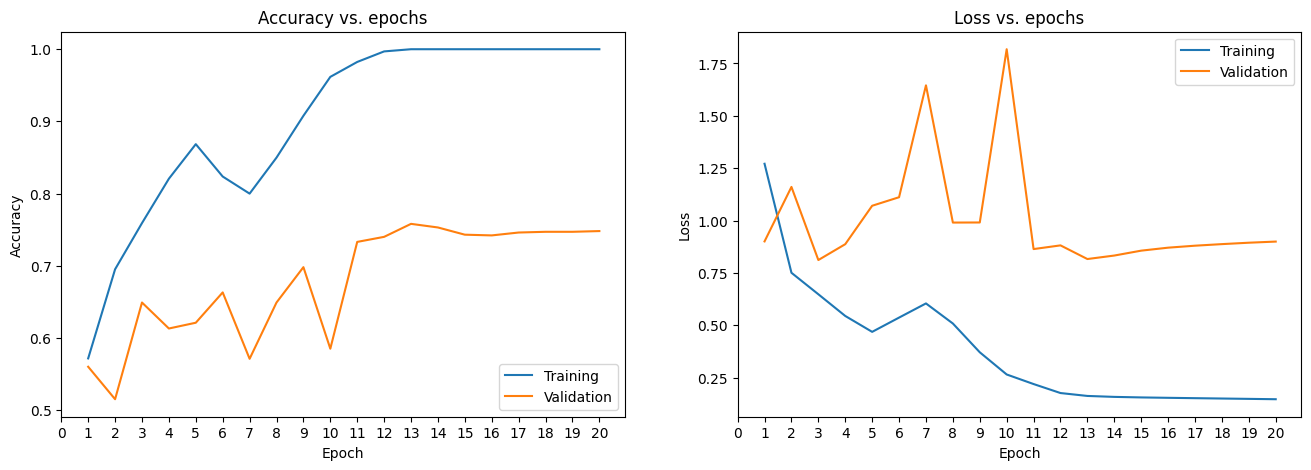

2022-08-17 06:13:53,706: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/resnet_v1_20
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 2s 42ms/step


2022-08-17 06:14:13,190: INFO: test loss:0.8164
2022-08-17 06:14:13,191: INFO: test accuracy:0.7580
2022-08-17 06:14:13,195: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/results.json
2022-08-17 06:14:13,197: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/results.json
2022-08-17 06:14:13,197: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator
2022-08-17 06:14:13,198: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator
2022-08-17 06:14:13,199: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_10

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-17 06:14:14,237: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator


32/32 [==============================] - 1s 11ms/step


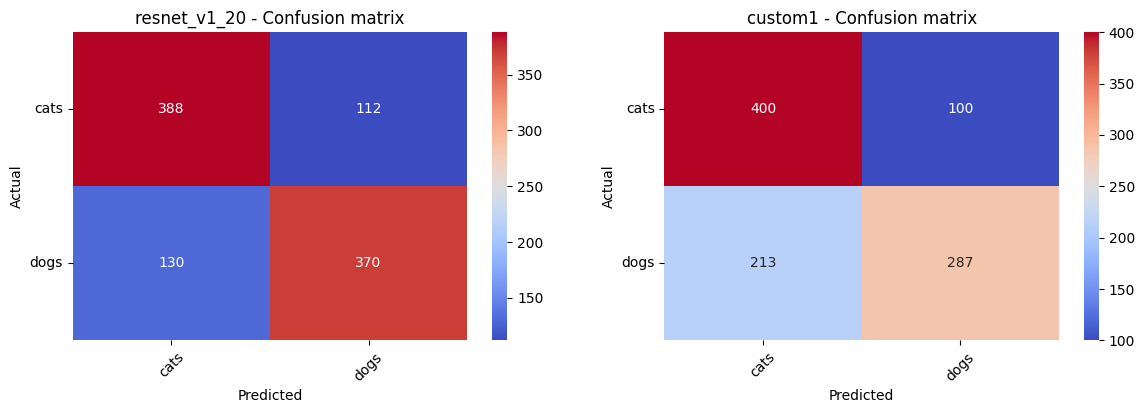

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  train_time  \
1  resnet_v1_20  catsdogs_0808_cnt_1000.ipynb         275618       314.5   
2       custom1  catsdogs_0808_cnt_1000.ipynb        1383938        98.1   
3          mlp1  catsdogs_0808_cnt_1000.ipynb        9830786        20.6   
4          vgg8  catsdogs_0808_cnt_1000.ipynb       14254786       295.0   
5        lenet1  catsdogs_0808_cnt_1000.ipynb        2785850        32.7   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-17 06:14      0.1710     0.8164          0.9980          0.758   
2  2022-08-17 06:03      0.4033     0.6511          0.8155          0.687   
3  2022-08-17 06:00      0.2677     3.3658          0.9190          0.597   
4  2022-08-17 06:08      0.6639     0.6842          0.5955          0.554   
5  2022-08-17 06:01      1.3731     1.3597          0.5400          0.549   

   train_auc  test_auc  
1     1.0000    0.8269  
2     0.9068    0.7664  
3     0.9722    0.6200  
4     0.6396    0.5746  
5     0.5511    0.5673

In [30]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20, preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Pretrained Model + Fune-Tune

In [31]:
input_shape = [160, 160, 3]

def resize(shape):
    def resize_(x):
        return tf.image.resize(x, shape)
    return resize_

In [32]:
preprocess_fun =  [rescale]

(32, 160, 160, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


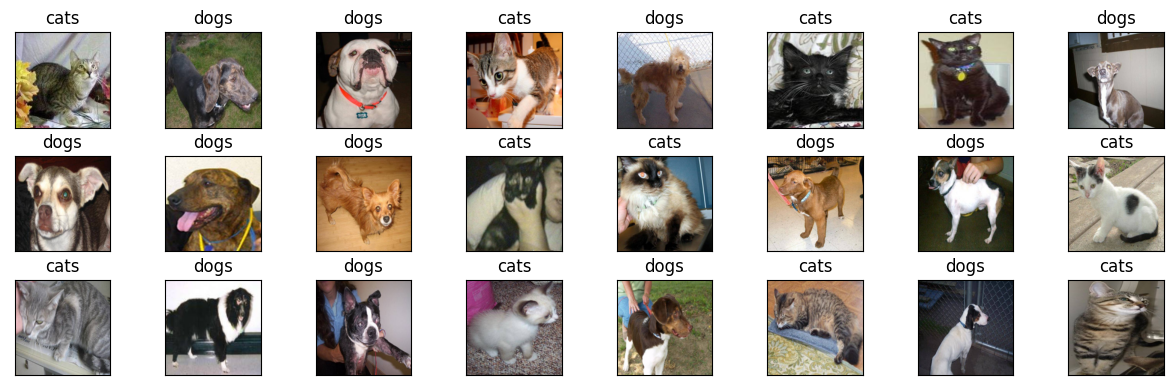

In [33]:
sample_images1 = resize(input_shape[:-1])(sample_images)
print(sample_images1.shape, type(sample_images1)) 
qtf.utils.show_images(sample_images1.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

#### MobileNet V2

In [34]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_6[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [35]:
def pretrained_model(helper, base_model, dropout=None, name='pretrained_model', last_activation=None, preprocess_fun=None):
    if dropout is None:
        dropout = helper.params.get_model_param(name, 'dropout')

    input_shape = qbz95.tf.classification.get_input_shape(helper.datasets.train_dataset)
    input = layers.Input(shape=input_shape)
    x = qbz95.tf.classification.image_models.process_funs(input, preprocess_fun)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    if dropout > 0: x = layers.Dropout(dropout)(x)
    x = helper.get_dense_layer(len(helper.params.classes), activation=last_activation)(x)

    model = Model(inputs=input, outputs=x, name=name)
    helper.compile(model)
    return model

def fine_tuning(helper, model, base_model, fine_tune_at, learning_rate=0.00001):
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=helper.params.metrics)
    return model 

In [36]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = pretrained_model(helper, base_model, dropout=0.2, name='pretrained-MobileNetV2', preprocess_fun=preprocess_fun)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')
model.summary()

loss0, accuracy0 = model.evaluate(datasets.test_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2022-08-17 06:14:22,387: INFO: model_params.pretrained-MobileNetV2.learning_rate=0.0001
2022-08-17 06:14:22,388: INFO: model_params.pretrained-MobileNetV2.clip_value=None
2022-08-17 06:14:22,397: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2


len(model.trainable_variables)=2
Model: "pretrained-MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_10 (Dropout)        (None, 1280)              0         
                                                                 
 dense_10 (

2022-08-17 06:14:25,953: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-17 06:14:25,954: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 06:14:25,955: INFO: steps_per_epoch=62
2022-08-17 06:14:25,956: INFO: start training
2022-08-17 06:14:25,957: INFO: use_class_weight=False


Epoch 1/10
62/62 [==============================] - ETA: 0s - loss: 0.7356 - accuracy: 0.6033

2022-08-17 06:14:48,577: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


2022-08-17 06:14:53,512: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


62/62 [==============================] - 28s 418ms/step - loss: 0.7356 - accuracy: 0.6033 - val_loss: 0.4481 - val_accuracy: 0.8080
Epoch 2/10
61/62 [============================>.] - ETA: 0s - loss: 0.4081 - accuracy: 0.8212

2022-08-17 06:15:14,623: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


2022-08-17 06:15:19,517: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


62/62 [==============================] - 26s 425ms/step - loss: 0.4047 - accuracy: 0.8231 - val_loss: 0.2634 - val_accuracy: 0.9210
Epoch 3/10
62/62 [==============================] - ETA: 0s - loss: 0.2700 - accuracy: 0.8962

2022-08-17 06:15:40,509: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


2022-08-17 06:15:45,279: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


62/62 [==============================] - 26s 422ms/step - loss: 0.2700 - accuracy: 0.8962 - val_loss: 0.1875 - val_accuracy: 0.9500
Epoch 4/10
62/62 [==============================] - ETA: 0s - loss: 0.1972 - accuracy: 0.9264

2022-08-17 06:16:06,003: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


2022-08-17 06:16:10,720: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


62/62 [==============================] - 25s 416ms/step - loss: 0.1972 - accuracy: 0.9264 - val_loss: 0.1493 - val_accuracy: 0.9590
Epoch 5/10
61/62 [============================>.] - ETA: 0s - loss: 0.1680 - accuracy: 0.9431

2022-08-17 06:16:31,759: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


2022-08-17 06:16:36,536: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


62/62 [==============================] - 26s 423ms/step - loss: 0.1663 - accuracy: 0.9441 - val_loss: 0.1259 - val_accuracy: 0.9630
Epoch 6/10
61/62 [============================>.] - ETA: 0s - loss: 0.1504 - accuracy: 0.9457

2022-08-17 06:16:57,782: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


2022-08-17 06:17:02,311: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


62/62 [==============================] - 26s 420ms/step - loss: 0.1487 - accuracy: 0.9466 - val_loss: 0.1106 - val_accuracy: 0.9670
Epoch 7/10
61/62 [============================>.] - ETA: 0s - loss: 0.1243 - accuracy: 0.9595

2022-08-17 06:17:22,320: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


2022-08-17 06:17:27,046: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


62/62 [==============================] - 25s 405ms/step - loss: 0.1229 - accuracy: 0.9602 - val_loss: 0.0995 - val_accuracy: 0.9710
Epoch 8/10
62/62 [==============================] - ETA: 0s - loss: 0.1219 - accuracy: 0.9582

2022-08-17 06:17:47,974: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


2022-08-17 06:17:52,754: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


62/62 [==============================] - 26s 422ms/step - loss: 0.1219 - accuracy: 0.9582 - val_loss: 0.0910 - val_accuracy: 0.9740
Epoch 9/10
61/62 [============================>.] - ETA: 0s - loss: 0.1108 - accuracy: 0.9611

2022-08-17 06:18:13,732: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


2022-08-17 06:18:18,521: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


62/62 [==============================] - 26s 421ms/step - loss: 0.1095 - accuracy: 0.9617 - val_loss: 0.0843 - val_accuracy: 0.9760
Epoch 10/10
62/62 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.9662

2022-08-17 06:18:39,268: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


2022-08-17 06:18:44,037: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


62/62 [==============================] - 26s 425ms/step - loss: 0.1021 - accuracy: 0.9662 - val_loss: 0.0787 - val_accuracy: 0.9770


2022-08-17 06:18:45,303: INFO: finish training [elapsed time: 259.35 seconds]


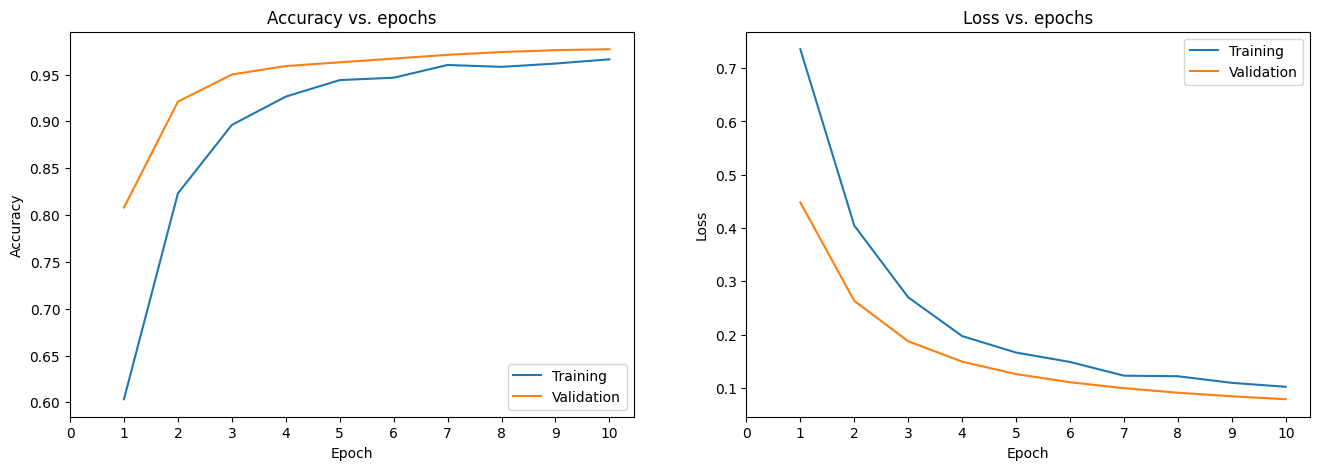

In [37]:
history = helper.train(model, epochs=10)

In [38]:
model = fine_tuning(helper, model, base_model, fine_tune_at=100, learning_rate=0.00001)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')

len(model.trainable_variables)=56


2022-08-17 06:18:45,825: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-17 06:18:45,826: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 06:18:45,828: INFO: steps_per_epoch=62
2022-08-17 06:18:45,829: INFO: start training
2022-08-17 06:18:45,829: INFO: use_class_weight=False


Epoch 1/10
61/62 [============================>.] - ETA: 0s - loss: 0.0639 - accuracy: 0.9754

2022-08-17 06:19:13,232: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


2022-08-17 06:19:18,797: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2/assets


62/62 [==============================] - 34s 467ms/step - loss: 0.0629 - accuracy: 0.9758 - val_loss: 0.0428 - val_accuracy: 0.9850
Epoch 2/10
62/62 [==============================] - 4s 61ms/step - loss: 0.0276 - accuracy: 0.9914 - val_loss: 0.0446 - val_accuracy: 0.9780
Epoch 3/10
62/62 [==============================] - 4s 61ms/step - loss: 0.0124 - accuracy: 0.9970 - val_loss: 0.0418 - val_accuracy: 0.9820
Epoch 4/10
62/62 [==============================] - 4s 61ms/step - loss: 0.0101 - accuracy: 0.9970 - val_loss: 0.0398 - val_accuracy: 0.9830
Epoch 5/10
62/62 [==============================] - 4s 61ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0664 - val_accuracy: 0.9740
Epoch 6/10
62/62 [==============================] - 4s 61ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0620 - val_accuracy: 0.9800
Epoch 7/10
62/62 [==============================] - 4s 62ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.0583 - val_accuracy: 0.9820
Epoch 8/10
62/62 [====

2022-08-17 06:19:53,885: INFO: finish training [elapsed time: 68.06 seconds]


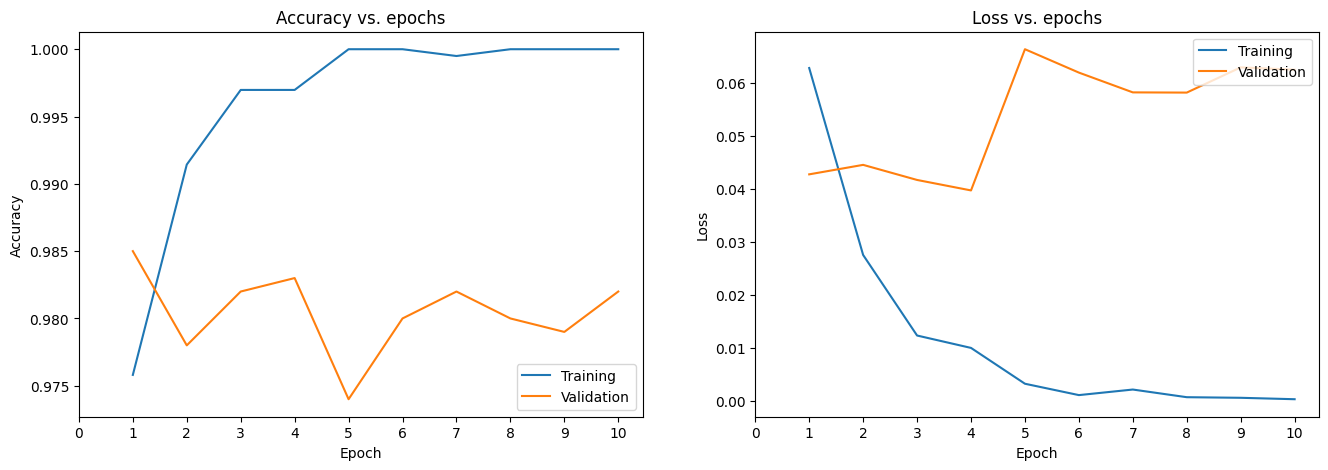

2022-08-17 06:19:54,245: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 1s 29ms/step


2022-08-17 06:20:18,489: INFO: test loss:0.0428
2022-08-17 06:20:18,490: INFO: test accuracy:0.9850
2022-08-17 06:20:18,493: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/results.json
2022-08-17 06:20:18,495: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/results.json
2022-08-17 06:20:18,496: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator
2022-08-17 06:20:18,498: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator
2022-08-17 06:20:18,498: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_10

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-17 06:20:23,308: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator


32/32 [==============================] - 3s 60ms/step


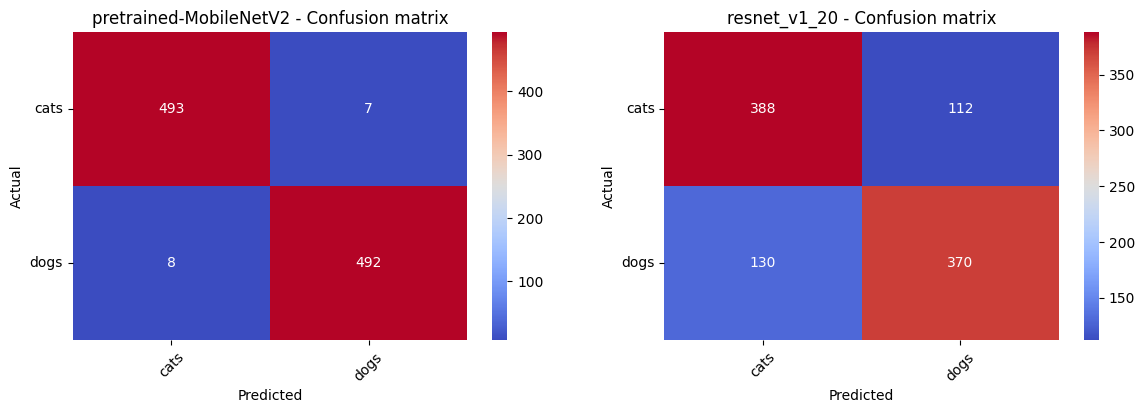

----------------------------------------models----------------------------------------


model_name                  program_name  weight_number  \
1  pretrained-MobileNetV2  catsdogs_0808_cnt_1000.ipynb        1864002   
2            resnet_v1_20  catsdogs_0808_cnt_1000.ipynb         275618   
3                 custom1  catsdogs_0808_cnt_1000.ipynb        1383938   
4                    mlp1  catsdogs_0808_cnt_1000.ipynb        9830786   
5                    vgg8  catsdogs_0808_cnt_1000.ipynb       14254786   
6                  lenet1  catsdogs_0808_cnt_1000.ipynb        2785850   

   train_time       create_time  train_loss  test_loss  train_accuracy  \
1        68.1  2022-08-17 06:20      0.0235     0.0428          0.9935   
2       314.5  2022-08-17 06:14      0.1710     0.8164          0.9980   
3        98.1  2022-08-17 06:03      0.4033     0.6511          0.8155   
4        20.6  2022-08-17 06:00      0.2677     3.3658          0.9190   
5       295.0  2022-08-17 06:08      0.6639     0.6842          0.5955   
6        32.7  2022-08-17 06:01      1.3731     1.3597          0.5400   

   test_accuracy  train_auc  test_auc  
1          0.985     0.9996    0.9988  
2          0.758     1.0000    0.8269  
3          0.687     0.9068    0.7664  
4          0.597     0.9722    0.6200  
5          0.554     0.6396    0.5746  
6          0.549     0.5511    0.5673

In [39]:
history = helper.train(model, epochs=10)
helper.model_summary(model, history, show_sample_analysis=False) 

## Evaluation

### Best Model

In [40]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2022-08-17 06:20:29,058: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs
2022-08-17 06:20:29,059: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/results.json


model_name                  program_name  weight_number  \
1  pretrained-MobileNetV2  catsdogs_0808_cnt_1000.ipynb        1864002   
2            resnet_v1_20  catsdogs_0808_cnt_1000.ipynb         275618   
3                 custom1  catsdogs_0808_cnt_1000.ipynb        1383938   
4                    mlp1  catsdogs_0808_cnt_1000.ipynb        9830786   
5                    vgg8  catsdogs_0808_cnt_1000.ipynb       14254786   
6                  lenet1  catsdogs_0808_cnt_1000.ipynb        2785850   

   train_time       create_time  train_loss  test_loss  train_accuracy  \
1        68.1  2022-08-17 06:20      0.0235     0.0428          0.9935   
2       314.5  2022-08-17 06:14      0.1710     0.8164          0.9980   
3        98.1  2022-08-17 06:03      0.4033     0.6511          0.8155   
4        20.6  2022-08-17 06:00      0.2677     3.3658          0.9190   
5       295.0  2022-08-17 06:08      0.6639     0.6842          0.5955   
6        32.7  2022-08-17 06:01      1.3731     1.3597          0.5400   

   test_accuracy  train_auc  test_auc  
1          0.985     0.9996    0.9988  
2          0.758     1.0000    0.8269  
3          0.687     0.9068    0.7664  
4          0.597     0.9722    0.6200  
5          0.554     0.6396    0.5746  
6          0.549     0.5511    0.5673

In [41]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2022-08-17 06:20:29,138: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2
2022-08-17 06:20:40,593: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator
2022-08-17 06:20:40,619: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/resnet_v1_20
2022-08-17 06:20:45,261: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator
2022-08-17 06:20:45,271: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/custom1
2022-08-17 06:20:46,300: INFO: loading generator from /tf/eipi10/xu

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

1/1 [==============================] - 0s 150ms/step


2022-08-17 06:20:50,680: WARNING: 5 out of the last 36 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f933bfa1e50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 52ms/step


2022-08-17 06:20:51,152: WARNING: 6 out of the last 37 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f933bf70ee0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 12ms/step


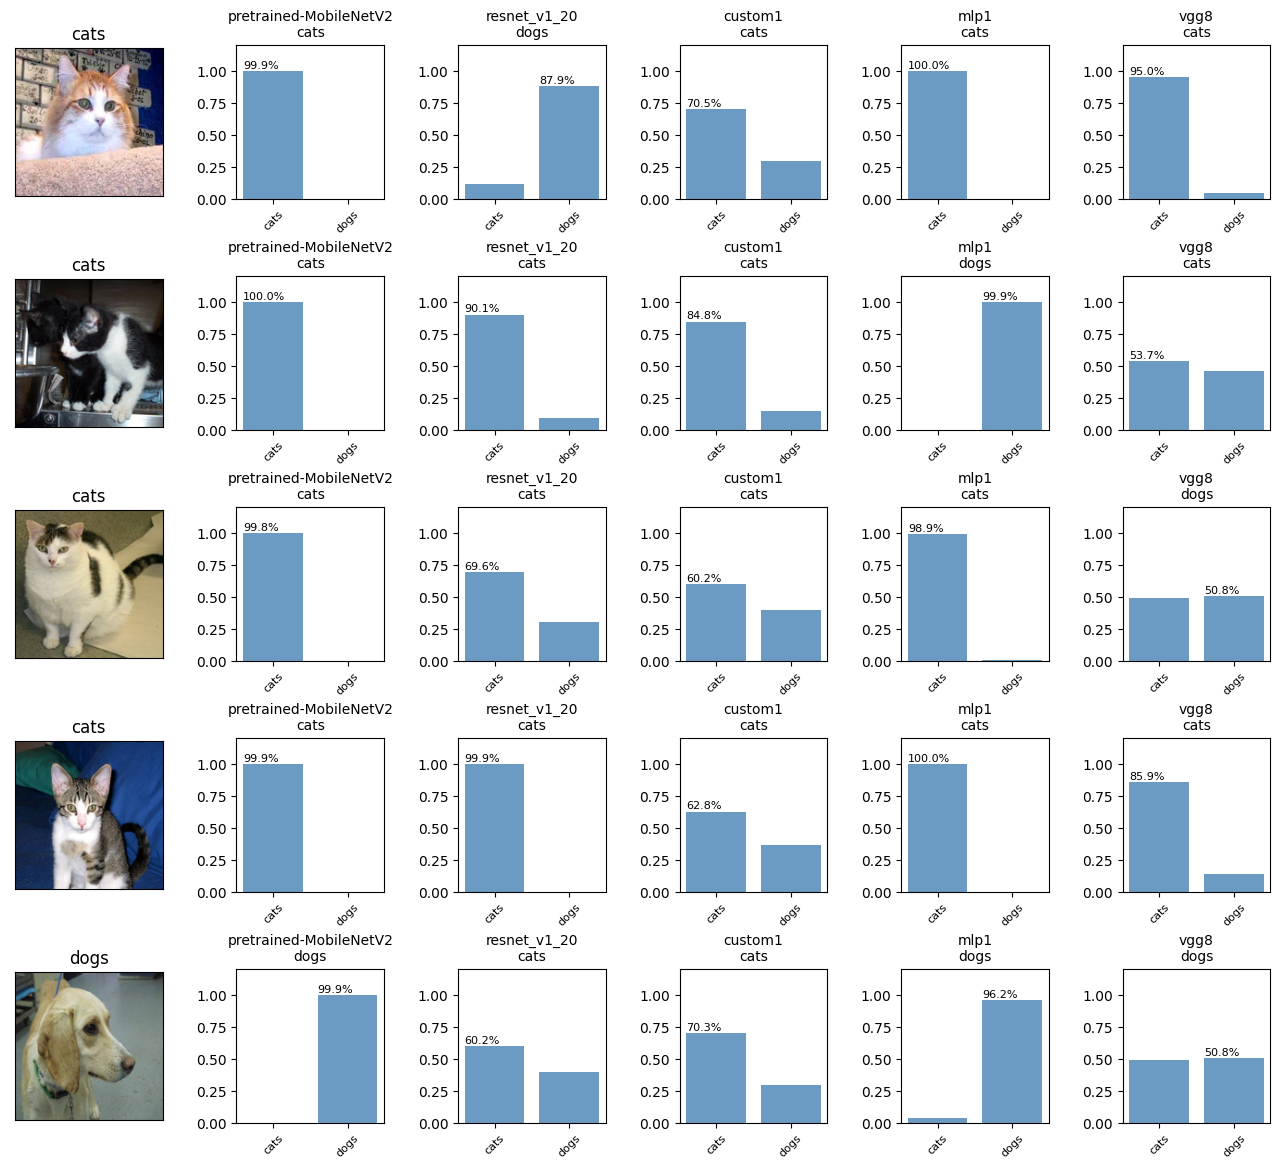

In [42]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

1/1 [==============================] - 0s 15ms/step


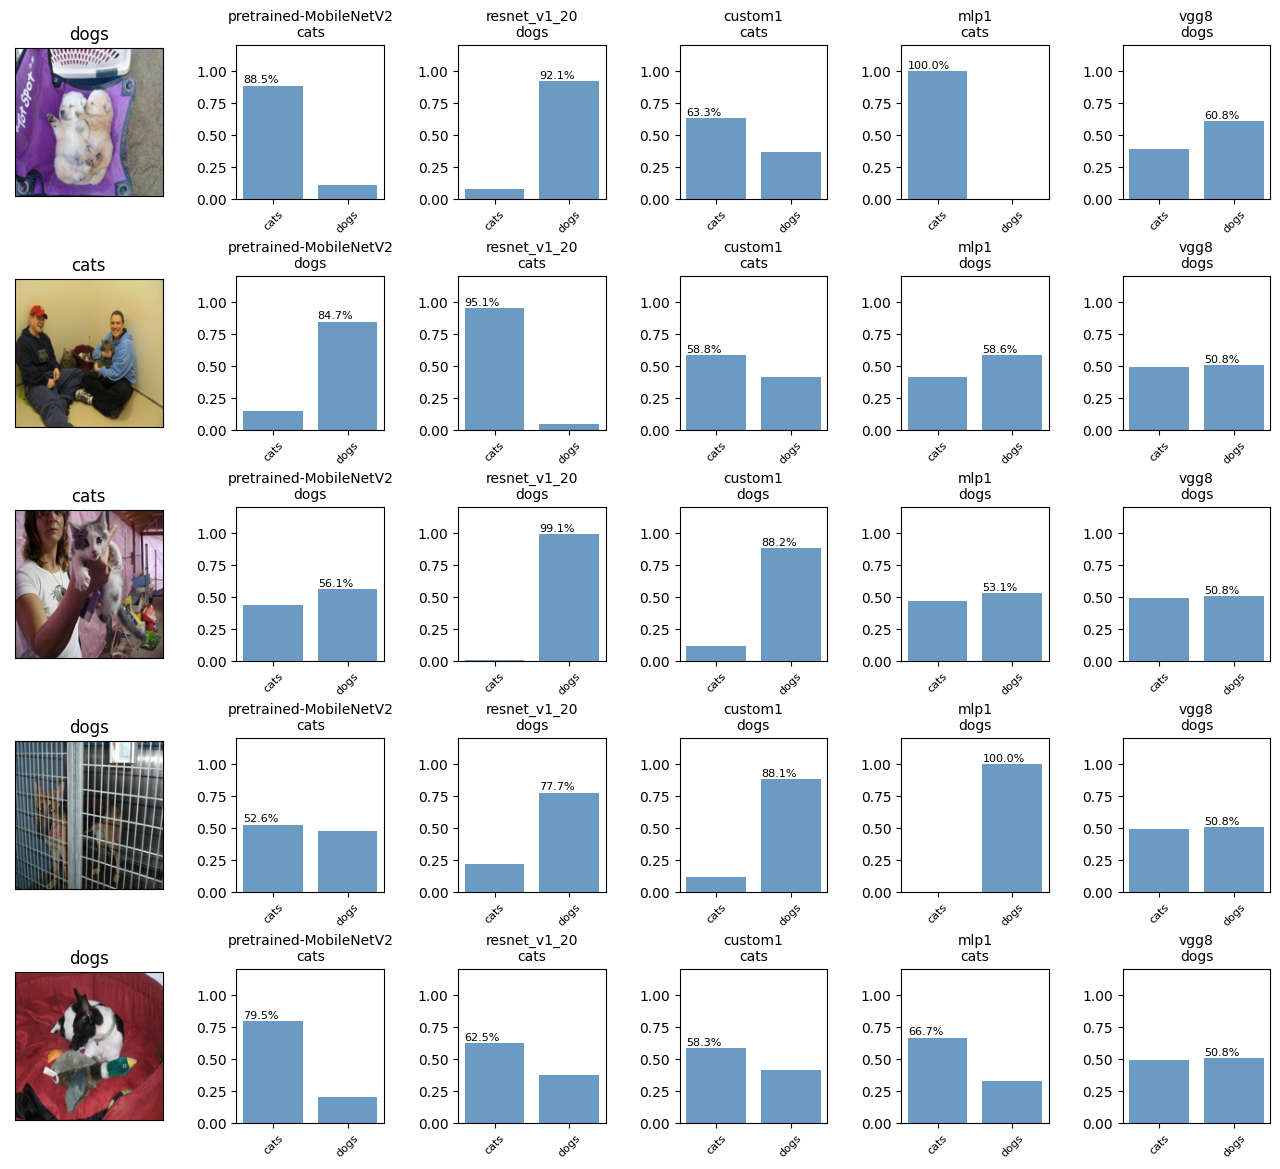

In [43]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### Evaluate

In [44]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.04282158985733986, 'accuracy': 0.9850000143051147, 'mae': 3.4052228927612305}
32/32 [==============================] - 1s 30ms/step
(1000, 2)


In [45]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

32/32 [==============================] - 1s 30ms/step


precision  recall        f1
cats   0.984032   0.986  0.985015
dogs   0.985972   0.984  0.984985

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

        cats     0.9840    0.9860    0.9850       500
        dogs     0.9860    0.9840    0.9850       500

    accuracy                         0.9850      1000
   macro avg     0.9850    0.9850    0.9850      1000
weighted avg     0.9850    0.9850    0.9850      1000



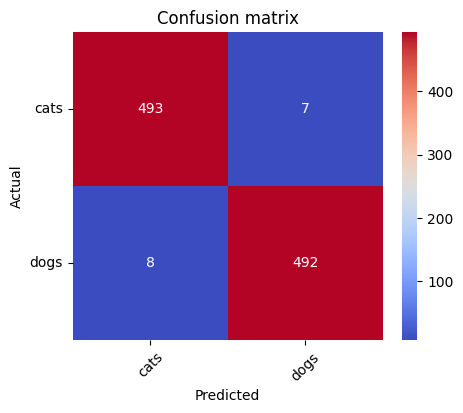

In [46]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## Reference

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)